# this notebook produce rough estimates of RR from the patch signals
# results are used in Omer's grant

In [46]:
import numpy as np
import argparse

import os
import math
import json

import pandas as pd
from sklearn.linear_model import LinearRegression

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures


import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
# from plotting_tools import *
# from stage1_patch import *
# from TimeStampReader import *
# from Subject import *
from resp_module import *
from preprocessing import *
from ECG_module import *
# from PPG_module import *
from evaluate import *
from stage1_cosmed import *
from stage3_preprocess import *
from dataIO import *

from importlib import reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
# parser.add_argument('--subject_id', metavar='subject_id', help='subject_id',
#                     default='101')
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')


# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/stage2/', 
                          '--output_folder', '../../data/stage3_RRest/',
#                           '--subject_id', 'sub118',
                          '--training_params_file', 'training_params.json',
                         ])
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/stage2/', output_folder='../../data/stage3_RRest/', training_params_file='training_params.json')


In [3]:
Fs = FS_RESAMPLE
Fs

250

In [4]:
inputdir = args.input_folder
outputdir = args.output_folder
# subject_id = args.subject_id

if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
# outputdir_sub = outputdir+subject_id+'/'
# if not os.path.exists(outputdir_sub):
#     os.makedirs(outputdir_sub)
    
training_params_file = args.training_params_file


In [5]:
with open(training_params_file) as json_file:
    training_params_list = json.load(json_file)
    
training_params = training_params_list[0]

In [6]:
training_params

{'list_signal': ['ECG', 'accelZ', 'ppg_r_1'],
 'list_feature': ['VE_cosmed', 'HR_patch'],
 'list_output': ['RR_cosmed',
  'VT_cosmed',
  'EE_cosmed',
  'SPO2_cosmed',
  'HR_cosmed',
  'VO2_cosmed',
  'resp_cosmed'],
 'list_meta': ['subject_id', 'task'],
 'FS_RESAMPLE_DL': 100,
 'window_size': 60,
 'overlap': 0.9}

In [7]:
list_signal = training_params['list_signal']
list_feature = training_params['list_feature']
list_output = training_params['list_output']
list_meta = training_params['list_meta']
FS_RESAMPLE_DL = training_params['FS_RESAMPLE_DL']
window_size = training_params['window_size'] # s
overlap = training_params['overlap'] # out of 1

In [74]:
stationary_names = ['Baseline 0']
for j in range(5):
    stationary_names.append('Recovery ' + str(j))
# stationary_names.append( '6MWT 0' )
# stationary_names.append( '6MWT-R 0' )
# stationary_names.append( 'Stair 0' )
# stationary_names.append( 'Walk 0' )
# stationary_names.append( 'Run 0' )

stationary_names

['Baseline 0',
 'Recovery 0',
 'Recovery 1',
 'Recovery 2',
 'Recovery 3',
 'Recovery 4']

# get sync data

## change activity name
## maybe remove scaling

105 ECG
108 ECG
109 ECG
112 cosmed
115

In [75]:
no_scaling = False

df_sync = []
for i in range(20):
    print(i+101)
    subject_id = 'sub'+str(i+101)
    
#     if subject_id =='sub105' or subject_id =='sub108' or subject_id =='sub109' or subject_id =='sub112' or subject_id =='sub117':
    if subject_id =='sub112':
        continue
#     if subject_id !='sub106':
#         print(subject_id)
#         continue
    
    inputdir_sub = inputdir+subject_id+'/'
    if subject_id not in os.listdir(inputdir):
        continue

    for syn_file in os.listdir(inputdir_sub):
        if '.feather'  in syn_file:
            df_sub = pd.read_feather(inputdir_sub+syn_file)
#             df_sub = filter_DFcolumns(df_sub.copy(), Fs)

#     sys.exit()
    # get raw task names except for Transition
    task_unique = df_sub['task'].unique()
    task_unique = task_unique[task_unique!='Transition']

#     df_sub = filter_DFcolumns(df_sub, Fs)
        
    for stationary_name in stationary_names:
        
        if 'Baseline' not in stationary_name and 'Recovery' not in stationary_name:
            stationary_name_new = stationary_name.split(' ')[0]
        else:

            # get recovery index
            i_recovery = np.where(task_unique==stationary_name)[0]

            # the index of the task associated with this recovery is i_recovery-1. Get its name
            task_name = task_unique[i_recovery-1][0]

            # spell out new recovery name
    #         recovery_name_new = ' '.join([recovery_name.split(' ')[0], task_name.split(' ')[0] ,recovery_name.split(' ')[1]])

            if 'Baseline' in stationary_name:
                stationary_name_new = stationary_name.split(' ')[0]
            else:
                stationary_name_new = ' '.join([stationary_name.split(' ')[0], task_name.split(' ')[0]])
        

        df_sub.loc[df_sub['task']==stationary_name, 'task'] = stationary_name_new
        
        if no_scaling:
            obj_cosmed = load_sub('../../data/stage1/'+subject_id+'/cosmed/data')
            print(obj_cosmed.Weight)
            df_sub['VT_cosmed'] = df_sub['VT_cosmed'] * obj_cosmed.Weight
            df_sub['VE_cosmed'] = df_sub['VE_cosmed'] * obj_cosmed.Weight
            df_sub['VO2_cosmed'] = df_sub['VO2_cosmed'] * obj_cosmed.Weight
            df_sub['VCO2_cosmed'] = df_sub['VCO2_cosmed'] * obj_cosmed.Weight
            df_sub['EE_cosmed'] = df_sub['EE_cosmed'] * obj_cosmed.Weight

#     df_sub = df_sub.loc[(df_sub['task'].str.contains("Baseline", case=False)) | (df_sub['task'].str.contains("Recovery", case=False)) | 
#                         (df_sub['task']=="6MWT") | (df_sub['task']=="6MWT-R") | (df_sub['task']=="Run") | (df_sub['task']=="Walk") | (df_sub['task']=="Stair")
#                        ].reset_index(drop=True)
    df_sub = df_sub.loc[(df_sub['task'].str.contains("Baseline", case=False)) | (df_sub['task'].str.contains("Recovery", case=False))].reset_index(drop=True)
    df_sub['subject_id'] = subject_id[3:]
    
    print(df_sub['task'].unique())

    df_sync.append(df_sub.copy())
    #     print((df_sync['task']==recovery_name).sum())
    
df_sync = pd.concat(df_sync).reset_index(drop=True)

101
['Baseline' 'Recovery 6MWT' 'Recovery 6MWT-R' 'Recovery Stair'
 'Recovery Walk' 'Recovery Run']
102
['Baseline' 'Recovery 6MWT' 'Recovery 6MWT-R' 'Recovery Stair'
 'Recovery Walk' 'Recovery Run']
103
['Baseline' 'Recovery 6MWT' 'Recovery 6MWT-R' 'Recovery Stair'
 'Recovery Walk' 'Recovery Run']
104
['Baseline' 'Recovery 6MWT-R' 'Recovery 6MWT' 'Recovery Stair'
 'Recovery Walk' 'Recovery Run']
105
['Baseline' 'Recovery 6MWT' 'Recovery 6MWT-R' 'Recovery Stair'
 'Recovery Walk' 'Recovery Run' 'Recovery 5']
106
['Baseline' 'Recovery 6MWT-R' 'Recovery 6MWT' 'Recovery Stair'
 'Recovery Walk' 'Recovery Run' 'Recovery 5']
107
['Baseline' 'Recovery 6MWT-R' 'Recovery 6MWT' 'Recovery Stair'
 'Recovery Walk' 'Recovery Run']
108
['Baseline' 'Recovery 6MWT' 'Recovery 6MWT-R' 'Recovery Stair'
 'Recovery Walk' 'Recovery Run']
109
['Baseline' 'Recovery 6MWT-R' 'Recovery 6MWT' 'Recovery Stair'
 'Recovery Walk' 'Recovery Run']
110
['Baseline' 'Recovery 6MWT' 'Recovery 6MWT-R' 'Recovery Stair'
 'Recov

In [76]:
df_sync['task'].unique()

array(['Baseline', 'Recovery 6MWT', 'Recovery 6MWT-R', 'Recovery Stair',
       'Recovery Walk', 'Recovery Run', 'Recovery 5'], dtype=object)

# add HR_patch and resp_cosmed

In [77]:
df_sync['HR_patch'] = 0
df_sync['resp_cosmed'] = 0

for subject_id in df_sync['subject_id'].unique():


    df_sub = df_sync[df_sync['subject_id']==subject_id]
    outputdir_sub = outputdir+subject_id+'/'
    
    for task_name in df_sub['task'].unique():
        
#         if subject_id!='111':
#             continue
#         if task_name!='Recovery Run':
#             continue
        print('sub: {}, task: {}'.format(subject_id, task_name))
        df_task = df_sub[df_sub['task']==task_name]
        ECG_raw_patch = df_task['ECG'].values
        
        fig_name = 'ECG_diagnostics_'+task_name
        QRS_detector_dict_patch = task_HR_detector(ECG_raw_patch, Fs, fig_name=fig_name, outputdir=outputdir_sub, show_plot=False)
        
        fig_name = 'physio_diagnostics_'+task_name
        plot_inputsigs(df_task, Fs, fig_name=fig_name, outputdir=outputdir_sub, show_plot=False)
#         if subject_id=='102':
#         sys.exit()

        def get_RRVT2resp(df_task, Fs):
            f_arr_raw = df_task['RR_cosmed'].values/60
            t_arr = np.arange(df_task.shape[0])/Fs
            # smooth it since it's usally digital and disgusting
            f_arr = get_smooth(f_arr_raw, N=Fs*5)
            # v_arr is the simulated sinusoidal breath signal, sampled eqaully as t_arr
            v_arr, f_sim_interp = get_sim_breath(t_arr, f_arr, downsample_factor=Fs//5) # Fs=500Hz
            resp_cosmed = v_arr*df_task['VT_cosmed']/2
            
            return resp_cosmed

        resp_cosmed = get_RRVT2resp(df_task, Fs)
        
        t_ecg = np.arange(ECG_raw_patch.shape[0])/Fs
        hr_interp = np.interp(t_ecg, QRS_detector_dict_patch['ts_hr'], QRS_detector_dict_patch['hr'])
        
        df_sync.loc[(df_sync['subject_id']==subject_id) & (df_sync['task']==task_name), 'HR_patch'] = hr_interp
        df_sync.loc[(df_sync['subject_id']==subject_id) & (df_sync['task']==task_name), 'resp_cosmed'] = resp_cosmed

sub: 101, task: Baseline
	 use S peaks
	 use S peaks
sub: 101, task: Recovery 6MWT
	 use S peaks
	 use S peaks
sub: 101, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
sub: 101, task: Recovery Stair
	 use S peaks
	 use S peaks
sub: 101, task: Recovery Walk
	 use S peaks
	 use S peaks
sub: 101, task: Recovery Run
	 use S peaks
	 use S peaks
sub: 102, task: Baseline
	 use S peaks
	 use S peaks
sub: 102, task: Recovery 6MWT
	 use S peaks
	 use S peaks
sub: 102, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
sub: 102, task: Recovery Stair
	 use S peaks
	 use S peaks
sub: 102, task: Recovery Walk
	 use S peaks
	 use S peaks
sub: 102, task: Recovery Run
	 use S peaks
	 use S peaks
sub: 103, task: Baseline
	 use S peaks
	 use S peaks
sub: 103, task: Recovery 6MWT
	 use S peaks
	 use S peaks
sub: 103, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
sub: 103, task: Recovery Stair
	 use S peaks
	 use S peaks
sub: 103, task: Recovery Walk
	 use S peaks
	 use S peaks
sub: 103, task: Recove

In [82]:
#         surrogate_dict['ECG_SR'] = ECG_SR_extraction(t_raw, ecg_beats_leading, i_beat_peaks_leading, filter_padded, Fs, highcutoff_br=highcutoff_br, br_smoothing_dur=br_smoothing_dur, offset_SR=offset_SR)
#         surrogate_dict['SCG_AMpt'] = SCG_AMpt_extraction(t_raw, acc_filt['accelZ'], filter_padded, Fs, highcutoff_br=1, br_smoothing_dur=br_smoothing_dur)
#         surrogate_dict['ECG_AMs'] = ECG_AM_extraction(t_raw, -ecg_filt, i_S_peaks, filter_padded, Fs, highcutoff_br=highcutoff_br, br_smoothing_dur=br_smoothing_dur)


In [113]:
def filt_DS_US(ts, Fs, sig, filter_padded, lowcutoff=0.08, highcutoff=1, downsample_factor=5):

    Fs_DS = Fs / downsample_factor # 100 Hz
    ts_DS = ts[::downsample_factor]
    sig_DS = np.interp(ts_DS, ts, sig)    
    sig_filt = get_padded_filt(sig_DS, filter_padded=filter_padded, lowcutoff=lowcutoff, highcutoff=highcutoff, Fs=Fs_DS)
    sig_filt = np.interp(ts, ts_DS, sig_filt)  

    return sig_filt

def ECG_SR_extraction(ts, sig_beats, i_beat_peaks, filter_padded, Fs, highcutoff_br=1, br_smoothing_dur=1, offset_SR=100):
    
    i=offset_SR-1
    ts_ECG_SR = ts[i_beat_peaks]
    sig_diff = np.gradient(sig_beats,axis=0)

    indicies_valleys = np.argsort(sig_diff,axis=0) # small to large, pick first and >i
    indicies_peaks = np.argsort(sig_diff*-1,axis=0) # large to small, pick first and < i

    i_slopemin = np.zeros(indicies_valleys.shape[1])
    for i_col in range(indicies_valleys.shape[1]):
        indices = indicies_valleys[:,i_col]
        i_slopemin[i_col] = indices[indices>=i][0]

        
    i_slopemax = np.zeros(indicies_peaks.shape[1])
    for i_col in range(indicies_peaks.shape[1]):
        indices = indicies_peaks[:,i_col]
        i_slopemax[i_col] = indices[indices<=i][0]

    i_slopemin = i_slopemin.astype(int)
    i_slopemax = i_slopemax.astype(int)

    slopemin = sig_diff[i_slopemin, np.arange(sig_diff.shape[1])]
    slopemax = sig_diff[i_slopemax, np.arange(sig_diff.shape[1])]

    sloperange = slopemax-slopemin


    ECG_SR_raw = np.interp(ts, ts_ECG_SR, sloperange)
    ECG_SR_smooth = get_smooth(ECG_SR_raw, N=int(Fs*br_smoothing_dur))
    
#     ECG_SR_filt = butter_filter('low', ECG_SR_smooth, highcutoff_br, Fs)
#     ECG_SR_filt = get_padded_filt(ECG_SR_smooth, filter_padded=filter_padded, lowcutoff=0.08, highcutoff=highcutoff_br, Fs=Fs)
   # downsample, filter, then upsample
    ECG_SR_filt = filt_DS_US(ts, Fs, ECG_SR_smooth, filter_padded, lowcutoff=0.08, highcutoff=highcutoff_br, downsample_factor=5)

    ECG_SR_normed = (ECG_SR_filt - ECG_SR_filt.mean()) / ECG_SR_filt.std()

    ECG_SR_dict = {
        'raw': ECG_SR_raw, 
        'smooth': ECG_SR_smooth,
        'filt': ECG_SR_filt,
        'normed': ECG_SR_normed,
    }
    return ECG_SR_dict

	 use S peaks
	 use S peaks


In [116]:
# QRS_detector_dict_patch.keys()
# highcutoff_br

array([-1.53124599, -1.53149703, -1.53174807, ..., -0.89770053,
       -0.8979639 , -0.8979639 ])

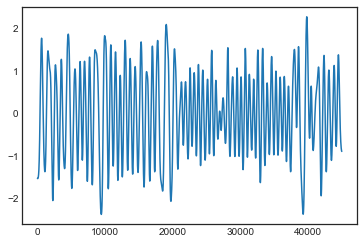

In [121]:
# plt.plot(aaa['normed'])

'119'

In [262]:
df_outputlabel = pd.DataFrame()
                
for subject_id in df_sync['subject_id'].unique():


    df_sub = df_sync[df_sync['subject_id']==subject_id]
    

    
    for task_name in df_sub['task'].unique():
        
#         if task_name !='Baseline':
#             continue
        print('sub: {}, task: {}'.format(subject_id, task_name))
        df_task = df_sub[df_sub['task']==task_name]
        
        RR_label =  df_task['RR_cosmed'].values.mean()

        for sig_name in df_task.columns:
            
            if 'ECG' not in sig_name and 'ppg' not in sig_name:
                continue
            
            if 'ECG' in sig_name:
                ECG_raw_patch = df_task[sig_name].values
                t_raw = df_task['time'].values

                QRS_detector_dict_patch = task_HR_detector(ECG_raw_patch, Fs, show_plot=False)
                
                i_beat_peaks_leading =  QRS_detector_dict_patch['i_beat_peaks_leading']
                ecg_beats_leading = QRS_detector_dict_patch['ecg_beats_leading']
                filter_padded = 5

                offset_SR = int(0.2*Fs)
                resp_sig = ECG_SR_extraction(t_raw, ecg_beats_leading, i_beat_peaks_leading, filter_padded, Fs, offset_SR=offset_SR)
                resp_sig = resp_sig['normed']
                
                freq, Pxx = get_PSD_scipy(resp_sig, Fs)

                i_max = np.argmax(Pxx.squeeze())
                RR_est_ecg = freq[i_max]*60
            
            

#                 if subject_id=='102':
#                     sys.exit()
                    
                    
            if 'ppg' in sig_name:
                if sig_name!='ppg_g_1':
                    continue

                sig = df_task[sig_name].values

                resp_sig = ppg_filter(sig, Fs)

#                 resp_sig = -get_padded_filt(sig, filter_padded=5, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=Fs)
#                 RR_label =  df_task['RR_cosmed'].values.mean()

                freq, Pxx = get_PSD_scipy(resp_sig, Fs)

                i_max = np.argmax(Pxx.squeeze())
                RR_est_ppg = freq[i_max]*60

            
#             print(sig_name)

        df_outputlabel = df_outputlabel.append(
            pd.DataFrame( {
            'subject_id': int(subject_id),
#             'label_est': RR_est,
            'label_est_ecg': RR_est_ecg,
            'label_est_ppg': RR_est_ppg,
            'label': RR_label,
            'sig_name': 'resp_ecg_ppg',
            'activity': [task_name]
            }), ignore_index=True )



    #     inspect_resp(sig, RR_label, Fs, fig_name=task)


sub: 101, task: Baseline
	 use S peaks
	 use S peaks
sub: 101, task: Recovery 6MWT
	 use S peaks
	 use S peaks
sub: 101, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
sub: 101, task: Recovery Stair
	 use S peaks
	 use S peaks
sub: 101, task: Recovery Walk
	 use S peaks
	 use S peaks
sub: 101, task: Recovery Run
	 use S peaks
	 use S peaks
sub: 102, task: Baseline
	 use S peaks
	 use S peaks
sub: 102, task: Recovery 6MWT
	 use S peaks
	 use S peaks
sub: 102, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
sub: 102, task: Recovery Stair
	 use S peaks
	 use S peaks
sub: 102, task: Recovery Walk
	 use S peaks
	 use S peaks
sub: 102, task: Recovery Run
	 use S peaks
	 use S peaks
sub: 103, task: Baseline
	 use S peaks
	 use S peaks
sub: 103, task: Recovery 6MWT
	 use S peaks
	 use S peaks
sub: 103, task: Recovery 6MWT-R
	 use S peaks
	 use S peaks
sub: 103, task: Recovery Stair
	 use S peaks
	 use S peaks
sub: 103, task: Recovery Walk
	 use S peaks
	 use S peaks
sub: 103, task: Recove

In [ ]:
inspect_resp(resp_sig, RR_label, Fs, fig_name=None)


In [263]:
df_outputlabel['diff'] = (df_outputlabel['label_est_ecg'] - df_outputlabel['label_est_ppg']).abs()
df_outputlabel['label_est'] = (df_outputlabel['label_est_ecg'] + df_outputlabel['label_est_ppg'])/2

In [267]:
df = df_outputlabel[df_outputlabel['diff']<0.3]
df

,subject_id,label_est_ecg,label_est_ppg,label,sig_name,activity,diff,label_est
3,101,25.856279,25.856279,25.581724,resp_ecg_ppg,Recovery Stair,0.0,25.856279
12,103,15.540958,15.540958,17.225167,resp_ecg_ppg,Baseline,0.0,15.540958
13,103,21.417445,21.417445,23.499363,resp_ecg_ppg,Recovery 6MWT,0.0,21.417445
17,103,41.283192,41.283192,38.424762,resp_ecg_ppg,Recovery Run,0.0,41.283192
18,104,15.700860,15.700860,16.995738,resp_ecg_ppg,Baseline,0.0,15.700860
20,104,18.239300,18.239300,19.376921,resp_ecg_ppg,Recovery 6MWT,0.0,18.239300
25,105,14.222085,14.222085,16.524053,resp_ecg_ppg,Recovery 6MWT,0.0,14.222085
27,105,14.972716,14.972716,16.902086,resp_ecg_ppg,Recovery Stair,0.0,14.972716
29,105,16.665926,16.665926,20.726009,resp_ecg_ppg,Recovery Run,0.0,16.665926
31,106,11.851982,11.851982,14.906804,resp_ecg_ppg,Baseline,0.0,11.851982


In [288]:
df_performance = get_df_performance3(df['label'].values, df['label_est'].values, '999')
df_performance

,subject_id,PCC,Rsquared,rmse,mae,mape
0,999,0.97021,0.904114,2.195747,1.722209,0.081996


In [300]:
MAE, PCC, Rsquared, N_sub

(array([1.72220876]), array([0.97020976]), array([0.90411385]), 16)

In [305]:
N_sub = len(df['subject_id'].unique())
# N_samples = df_outputlabel_val.shape[0]
# t_dur = N_samples*3/60
PCC = df_performance['PCC'].values[0]
Rsquared = df_performance['Rsquared'].values[0]
MAE = df_performance['mae'].values[0]


# title_str = '{} range: {:.1f}-{:.1f} {}'.format(task.split('_')[0], label_range[0], label_range[1], unit_dict[task_name])
textstr = 'MAE={:.2f} BPM\nPCC={:.2f}\nR2={:.2f}\nN_sub={}'.format(MAE, PCC, Rsquared, N_sub)

textstr
#     df_performance_val['rmse'].mean(), unit_dict[task_name], df_performance_val['mae'].mean(), unit_dict[task_name], df_performance_val['mape'].mean()*100, '%',
#     PCC, Rsquared,
#     N_sub, N_samples, t_dur)

'MAE=1.72 BPM\nPCC=0.97\nR2=0.90\nN_sub=16'

Text(0.6, 0.1, 'MAE=1.72 BPM\nPCC=0.97\nR2=0.90\nN_sub=16')

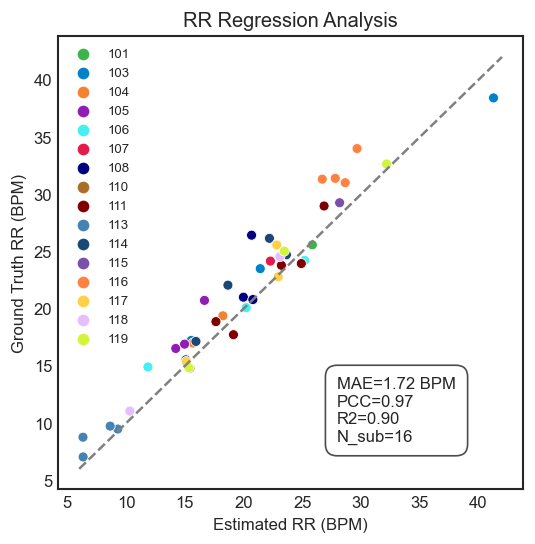

In [311]:
fig, ax = plt.subplots(1,1,figsize=(5,5), dpi=120)
props = dict(boxstyle='round,pad=0.7', facecolor='white', edgecolor='black', alpha=0.7)

fontsize = 15
sns.scatterplot(data=df, x="label_est", y="label", hue="subject_id", ax=ax, palette=subject_palette)
ax.legend(fontsize=fontsize-7)
#     ax.scatter(df['label_est'], df['label'])
ax.set_xlabel('Estimated RR (BPM)')
ax.set_ylabel('Ground Truth RR (BPM)')
ax.set_title('RR Regression Analysis')

def label_point(x, y, txt1, txt2, ax):
#         val = txt1+'_'+txt2
    a = pd.concat({'x': x, 'y': y, 'txt1': txt1, 'txt2': txt2}, axis=1)
    for i, point in a.iterrows():
#             print(point)
        ax.text(point['x']+.08, point['y'], str(point['txt1'])+'_'+str(point['txt2']), fontsize=5)

# label_point(df['label_est'], df['label'], df['subject_id'], df['activity'], ax=ax)
# ax.plot([5, 40], [5, 40], transform=ax.transAxes, )

ax.plot(get_RR_range()*60, get_RR_range()*60, '--', color='gray')

# # place a text box in bottom right in axes coords
ax.text(0.6, 0.1, textstr, transform=ax.transAxes, fontsize=fontsize-5,
        verticalalignment='bottom', horizontalalignment='left', bbox=props)


In [239]:
# fig, ax = plt.subplots(1,1,figsize=(50,2), dpi=100)

# # plt.plot(sig)
# ax.plot(resp_sig)

In [240]:
# plt.plot(df_task[sig_name].values)
# sig_name

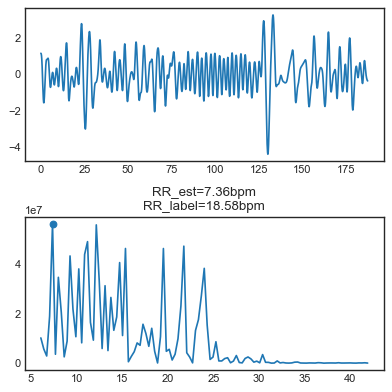

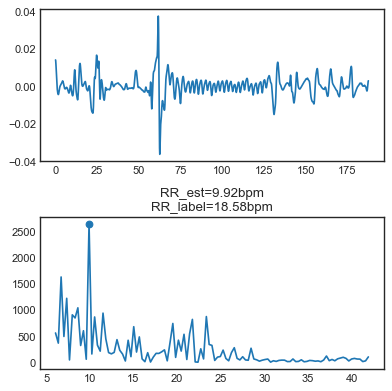

In [242]:
inspect_resp(resp_sig, RR_label, Fs, fig_name=None)


In [243]:
# inspect_resp(sig, RR_label, Fs, fig_name=None)


In [269]:
get_df_performance3(df_outputlabel['label'].values, df_outputlabel['label_est'].values, '000')


,subject_id,PCC,Rsquared,rmse,mae,mape
0,0,0.744305,0.147861,6.518501,4.261992,0.183834


In [210]:
# (diff>3).mean()

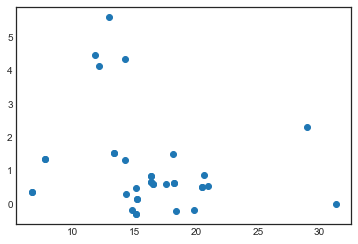

In [211]:
mean = (df_outputlabel['label'].values+df_outputlabel['label_est'].values)/2
diff = (df_outputlabel['label'].values-df_outputlabel['label_est'].values)/2

plt.scatter(mean, diff)
plt.show()

In [212]:

def get_df_performance3(label, label_est, subject_id):
    rmse = np.sqrt(mean_squared_error(label, label_est))

    mae, _ = get_MAE(label, label_est)
    mape, _ = get_MAPE(label, label_est)

    Rsquared = get_CoeffDeterm(label=label, predictions=label_est)

    PCC = get_PCC(label=label, est=label_est)
    
    df_performance = pd.DataFrame({
        'subject_id': [int(subject_id)],
        'PCC': [PCC],
        'Rsquared': [Rsquared],
        'rmse': [rmse],
        'mae': [mae],
        'mape': [mape],
    })
    
    return df_performance

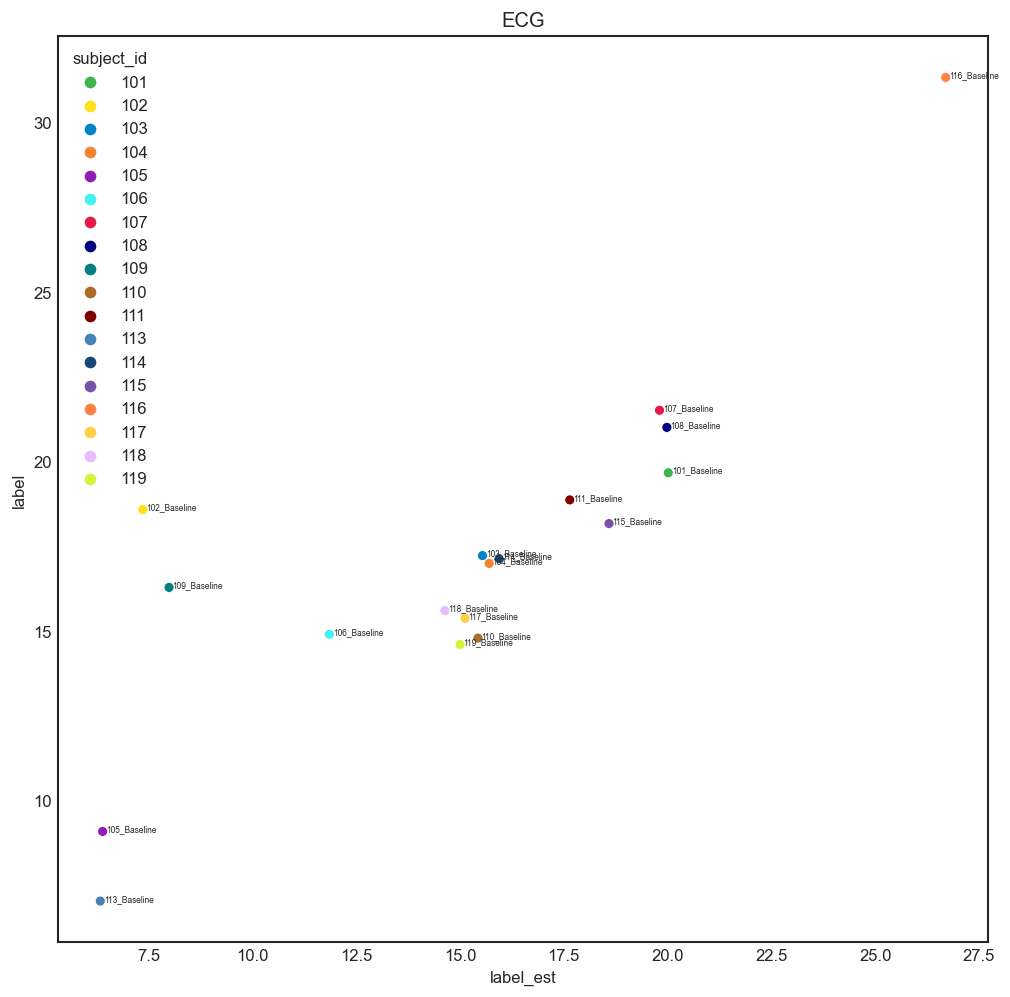

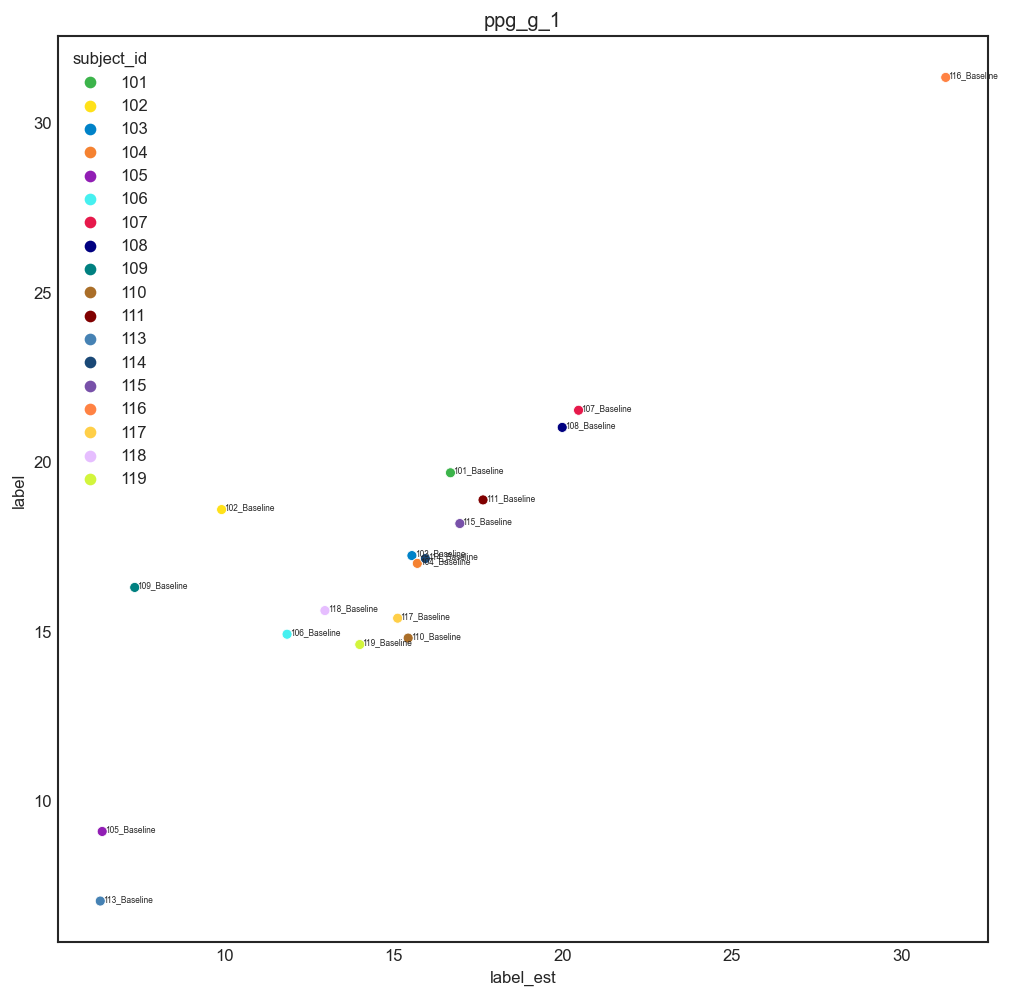

In [213]:

for sig_name in df_outputlabel['sig_name'].unique():
    
#     if sig_name != 'ECG':
# #     if sig_name != 'ppg_g_1':
#         continue
    df = df_outputlabel[df_outputlabel['sig_name']==sig_name]
    
    fig, ax = plt.subplots(1,1,figsize=(10,10), dpi=120)
    
    sns.scatterplot(data=df, x="label_est", y="label", hue="subject_id", ax=ax, palette=subject_palette)

#     ax.scatter(df['label_est'], df['label'])
    ax.set_xlabel('label_est')
    ax.set_ylabel('label')
    ax.set_title(sig_name)
    
    def label_point(x, y, txt1, txt2, ax):
#         val = txt1+'_'+txt2
        a = pd.concat({'x': x, 'y': y, 'txt1': txt1, 'txt2': txt2}, axis=1)
        for i, point in a.iterrows():
#             print(point)
            ax.text(point['x']+.08, point['y'], str(point['txt1'])+'_'+str(point['txt2']), fontsize=5)

    label_point(df['label_est'], df['label'], df['subject_id'], df['activity'], ax=ax)



In [81]:
df_performance

""


In [20]:
df_task = filter_DFcolumns(df_task.copy(), Fs)


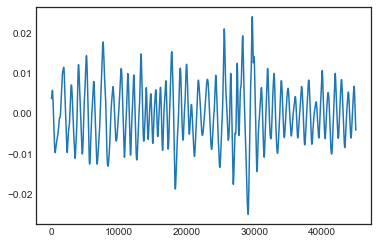

In [24]:
plt.plot(df_task['ppg_g_1'].values)

In [43]:
plot_regression(df_outputlabel_val, df_performance_val, task, show_plot=True, outputdir=outputdir)


ppg_g_1
ppg_r_1
ppg_ir_1
ppg_g_2
ppg_r_2
ppg_ir_2


In [36]:
# j = 1
# sig = dataloaders['val'].dataset.data[j, -1, :]
# RR_label = dataloaders['val'].dataset.label[j].squeeze()


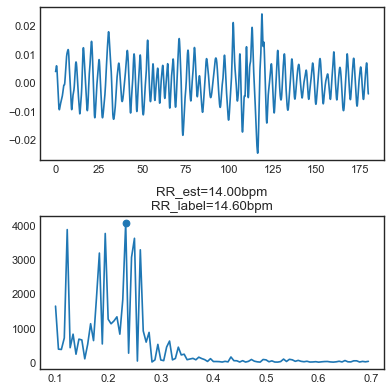

In [ ]:
# outputdir_train